# DS-GA 1003 Machine Learning

Student Name: Kuan-Lin Liu

## 1. Packages

In [16]:
# python 3.6
#!pip install -r requirements.txt
#!pip install joblib

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import json
import tqdm
from collections import Counter
from time import time

%matplotlib inline

## 2. Read Data

In [28]:
data_path = "fake-reviews/"

In [29]:
train = pd.read_csv(data_path+"train.csv")
val = pd.read_csv(data_path+"dev.csv")
test = pd.read_csv(data_path+"test.csv")
train.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


In [30]:
val[val["review"].apply(lambda x: len(x)==0)]

,ex_id,user_id,prod_id,rating,label,date,review


In [31]:
test.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,6,929,0,4.0,NaN,2009-08-25,Let me start with a shout-out to everyone who ...
1,9,932,0,5.0,NaN,2014-05-09,Stopped in for lunch today and couldn't believ...
2,14,937,0,4.0,NaN,2014-10-15,"Tiny little place, but very good food. Pastits..."
3,22,945,0,5.0,NaN,2014-04-10,Food was delicious and service was great. Good...
4,23,946,0,5.0,NaN,2014-03-29,Awesome hole in the wall place to grab a quick...


Merge train and val datasets for exploration.

In [32]:
data = pd.concat([train, val]).reset_index(drop=True)

In [66]:
temp_full_data = pd.concat([data, test]).reset_index(drop=True)

Create a column representing train, val,  and test in full_data.

Create a row index column

In [51]:
#len_train, len_val, len_test = len(train), len(val), len(test)
#full_data["datagroup"] = np.array([0]*len_train + [1]*len(val) + [2]*len(test))
full_data["row_id"] = range(len(full_data))

In [29]:
print("Full data dimension: {}".format(full_data.shape))
print("train+val data dimension: {}".format(data.shape))
print("Training data dimension: {}".format(train.shape))
print("Validation data dimension: {}".format(val.shape))
print("Test data dimension: {}".format(test.shape))
print("---")
print(data.dtypes)

Full data dimension: (358957, 10)
train+val data dimension: (286792, 7)
Training data dimension: (250874, 7)
Validation data dimension: (35918, 7)
Test data dimension: (72165, 7)
---
ex_id        int64
user_id      int64
prod_id      int64
rating     float64
label        int64
date        object
review      object
dtype: object


In [81]:
train.head()

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


The training data contains <font color='blue'>250,874</font> rows and the testing data contains <font color='blue'>35,918</font> rows. They both have <font color='blue'>7</font> columns.

In [97]:
#train.to_json("train.json", orient="records")

In [98]:
#val.to_json("dev.json", orient="records")

In [9]:
#test.to_json("test.json", orient="records")

## 3. Exploration

### 3.1. What is ex_id?

From the length of the unique data in ex_id, I guess it represents an index of the row.

Besides, I guess user_id and prod_id mean the index of users and products (items).

In [31]:
def unique_data_len(data, col_name):
    return data[col_name].unique().__len__()

print("Length of Unique Rows:")
for col in ["ex_id", "user_id", "prod_id", "rating", "label"]:
    print(col + ": {}".format(unique_data_len(data, col)))

Length of Unique Rows:
ex_id: 286792
user_id: 137692
prod_id: 923
rating: 5
label: 2


### 3.2. Rating

The "rating" column has 5 unique classes, 1 to 5.

Most people gave positive ratings, 4 and 5.

In [42]:
rating_count = pd.DataFrame(data["rating"].value_counts())
print(rating_count)

     rating
5.0  112518
4.0  108145
3.0   38026
2.0   16603
1.0   11500


In [58]:
sum(data["rating"]>=4)/len(data)

0.7694182543446121

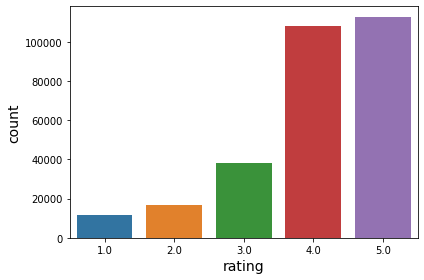

In [51]:
# fig = plt.figure(figsize=(5, 3))
sns.barplot(x=rating_count.index, y=rating_count["rating"])
plt.xlabel("rating", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.tight_layout()
# plt.savefig("fake-reviews/visualization/rating_count.png")

### 3.3. Review

The maximal length of reviews is 29012. The minimum is 1.

In [54]:
print(data["review"].apply(lambda row: len(row)).max())
print(data["review"].apply(lambda row: len(row)).min())

29012
1


The length of reviews has a left-skewed distribution.

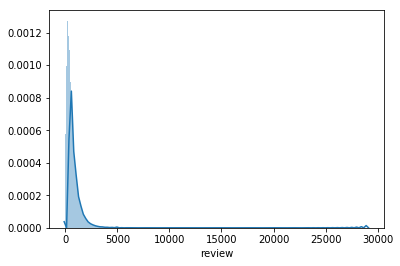

In [62]:
sns.distplot(
    data["review"].apply(lambda row: len(row)),
    bins = 500
)

### 3.4. Label

In [40]:
sum(data["label"]==1)/len(data)

0.1027469385477977

Text(0, 0.5, 'count')

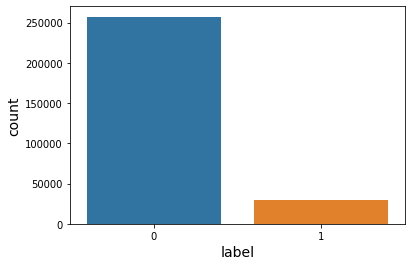

In [36]:
sns.barplot(x=data["label"].value_counts().index, y=data["label"].value_counts().values)
plt.xlabel("label", fontsize=14)
plt.ylabel("count", fontsize=14)
# plt.savefig("fake-reviews/visualization/label.png")

### 3.5. Label Vs. Rating

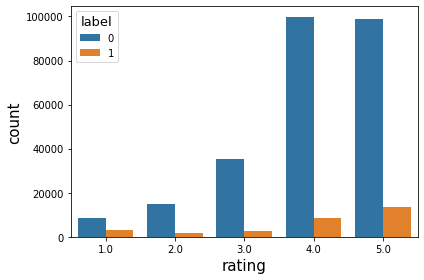

In [57]:
sns.countplot(x=data["rating"], hue=data["label"])
plt.xlabel("rating", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.legend(title="label", title_fontsize=13)
plt.tight_layout()
# plt.savefig("fake-reviews/visualization/rating-label.png")

### 3.6. Review Length

In [62]:
data["review_len"] = data["review"].apply(lambda row: len(row))

Remove review_len > 3000

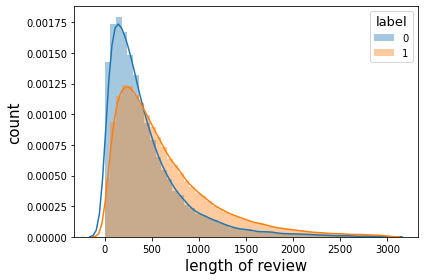

In [69]:
sns.distplot(data.loc[(data["review_len"]<3000) & (data["label"]==1),"review_len"], label="label: 1")
sns.distplot(data.loc[(data["review_len"]<3000) & (data["label"]==0),"review_len"], label="label: 0")
plt.xlabel("length of review", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.legend(title="label", labels=["0", "1"], title_fontsize=13)
plt.tight_layout()
# plt.savefig("fake-reviews/visualization/review-length.png")

## 4. Feature Engineering

We will create new features with train, val, and test sets together.

- Reviews Length Vs. Label

In [ ]:
full_data["review_len"] = full_data["review"].apply(lambda row: len(row))

- date_in and date_offset

In [53]:
# 2014-12-08 (object) => 20141208 (int)
full_data["date_int"] = pd.to_datetime(full_data["date"]).dt.strftime("%Y%m%d").apply(pd.to_numeric)
# How many seconds have passed since 1970-01-01
full_data["date_offset"] = (pd.to_datetime(full_data["date"]) - pd.to_datetime('1970-01-01')).dt.total_seconds().astype(int)

- is ever a spammer

In [54]:
# a spammer is a user with more than 0 fake reviews
df_spammer = full_data[['user_id','label']].groupby("user_id").sum().apply(lambda x: x>0).reset_index()
df_spammer.rename(columns = {'label':'spammer'}, inplace = True)
full_data = full_data.merge(df_spammer, on="user_id")

- count daily reviews

In [55]:
# count how many reviews per user per day
df_dailyreview = full_data[['user_id','date']].groupby(['user_id','date']).size().to_frame('size').reset_index()
# max reviews per day
df_dailyreview['max_daily_review'] = df_dailyreview[['user_id', 'size']].groupby(['user_id']).transform('max')
# avg reviews per day
df_dailyreview['avg_daily_review'] = df_dailyreview[['user_id', 'size']].groupby(['user_id']).transform('mean')
df_newdailyreview = df_dailyreview[['user_id', 'max_daily_review', 'avg_daily_review']].drop_duplicates(['user_id'])
full_data = full_data.merge(df_newdailyreview)

- positive and negative reviews

In [56]:
# super slow !@#$%^&*()$#@!@#@
# % positive reviews per user
full_data['pos_review_rate'] = full_data[['user_id','rating']].groupby(['user_id']).transform(lambda x: len(x[x >= 4]) / len(x))
# % negative reviews per user
full_data['neg_review_rate'] = full_data[['user_id','rating']].groupby(['user_id']).transform(lambda x: len(x[x <= 1]) / len(x))

- number of rating per user

In [57]:
# number of rating per user
full_data['num_user_rating'] = full_data[['user_id','rating']].groupby(['user_id']).transform('count')
# number of rating per product
full_data['num_prod_rating'] = full_data[['prod_id','rating']].groupby(['prod_id']).transform('count')
# summation of rating per product
full_data['sum_prod_rating'] = full_data[['prod_id','rating']].groupby(['prod_id']).transform('sum')
# compute absolute deviation from the average product rating for each review
# Formula from "Spotting Opinion Spammers using Behavioral Footprints"
full_data['review_dev'] = full_data[['rating','num_prod_rating', 'sum_prod_rating']].apply(
    lambda x: np.abs(x.rating - (x.sum_prod_rating - x.rating) / (x.num_prod_rating - 1)) / 4, axis=1)
# compute mean deviation per user
full_data['avg_user_dev'] = full_data[['user_id','review_dev']].groupby(['user_id']).transform('mean')

- first review & reviews within the first 7 month for each product

In [58]:
# First review date for each product
full_data['first_review_prod'] = full_data[['prod_id','date_offset']].groupby(['prod_id']).transform('min')
# Reviews written with the first 7 months
full_data['early_time_frame'] = full_data[['first_review_prod','date_offset']].apply(
    lambda x: np.maximum(0, 1 - (x.date_offset - x.first_review_prod) // 86400 / (7 * 30)), axis=1)

- first review for each user

In [59]:
# First review date for each user
full_data['first_review_user'] = full_data[['user_id','date_offset']].groupby(['user_id']).transform('min')
full_data['last_review_user'] = full_data[['user_id','date_offset']].groupby(['user_id']).transform('max')
# All reviews written in 28 days
full_data['burstiness'] = full_data[['first_review_user','last_review_user']].apply(
    lambda x: np.maximum(0, 1 - (x.last_review_user - x.first_review_user) // 86400 / 28), axis=1)

- sort by row_id and reset the index

In [62]:
full_data = full_data.sort_values("row_id")

In [74]:
full_data = full_data.reset_index(drop=True)

- save the new full dataset

In [81]:
# full_data.to_csv("fake-reviews/full_data.csv", index=False)

## 5. Text Preprocessing

- Lower
- Remove HTML
- Remove extra whitespace
- Convert accented characters to ASCII characters
- Expand contractions
- Remove special characters
- Lowercase all texts
- Convert number words to numeric form
- Remove numbers
- Remove stopwords
- Lemmatization

In [15]:
from bs4 import BeautifulSoup
import unidecode
from word2number import w2n
from pycontractions import Contractions
import gensim.downloader as api
from nltk.stem.snowball import SnowballStemmer
import spacy
import re
from tqdm import tqdm
tqdm.pandas()

In [18]:
#!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer(language='english')
# Choose model accordingly for contractions function
model = api.load("glove-twitter-25")
cont = Contractions(kv_model=model)
cont.load_models()

In [31]:
# reference from https://www.kaggle.com/andreinovikov90/nlp-2
def remove_html_tags(text):
    ''' remove html tags from text '''
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

def remove_extra_whitespace(text):
    ''' remove the extra whitespace '''
    text = text.strip()
    return " ".join(text.split())

def remove_accented_chars(text):
    ''' e.g. café -> cafe '''
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text):
    ''' expand shortened words, e.g. can't -> can not '''
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

def remove_url_address(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return text
         
def convert_lower_case(text):
    return text.lower()

def use_negative_word(nlp):
    ''' 
    1. remove no, not from the stopwords 
    2. nlp: nlp = en_core_web_sm.load()
    '''
    out_of_stopwords = ["not", "no"]
    for word in out_of_stopwords:
        nlp.vocab[word].is_stop = False
    return 

def preprocessing(text, nlp=nlp, remove_html=True, remove_whitespace=True, remove_accented=True, expand_contrac=True, use_negative=True, remove_url=True, convert_lower=True,
                  remove_stopword=True, remove_punctuation=True, remove_speical=True, remove_num=True, convert_to_num=False, stemming=False, lemmatization=True):
    ''' doing a series of preprocessing on the text data '''
    if remove_html == True:
        text = remove_html_tags(text)
    if remove_whitespace == True:
        text = remove_extra_whitespace(text)
    if remove_accented == True:
        text = remove_accented_chars(text)
    if expand_contrac == True:
        text = expand_contractions(text)
    if remove_url == True:
        text = remove_url_address(text)
    if convert_lower == True:
        text = convert_lower_case(text)
    if use_negative == True:
        use_negative_word(nlp)
    
    return text
#     # create tokens
#     token_list = nlp(text)
#     # prepare a clean token list
#     clean_tokens = []
#     # remove stop words, punctuations, special characters, number
#     for token in token_list:
#         pointer = True # remove the word if pointer is False
#         edited_token = token.text
        
#         # remove useless tokens
#         if remove_stopword == True and token.is_stop and token.pos_ != "NUM":
#             pointer = False
#         elif remove_punctuation == True and token.pos_ == "PUNCT" and pointer == True:
#             pointer == False
#         elif remove_speical == True and token.pos_ == "SYM" and pointer == True:
#             pointer = False
#         elif remove_num == True and (token.pos_ == "NUM" or token.text.isnumeric()) and pointer == True:
#             pointer = False
        
            
#         word number to numeric number
#         if convert_to_num == True and token.pos_ == "NUM" and pointer == True:
#             edited_token = w2n.word_to_num(token)
            
#         # stemming and lemmatization
#         if lemmatization == True and token.pos_ != "-PRON-" and pointer == True:
#             edited_token = token.lemma_
#         elif stemming == True and pointer == True:
#             edited_token = stemmer.stem(token)
        
#         # append edited token to the clean_tokens list
#         if edited_token != "" and pointer == True: # if it is not empty
#             clean_tokens.append(edited_token)
        
#     # return the token list
#     return clean_tokens

## 5. Word Embedding

### 5.1. Read preprocessed json file

In [71]:
import ndjson

In [72]:
def preproess_json_data(path):
    with open(path, "r") as file:
        json_data = ndjson.load(file)
    if "test" in path:
        data_dict = {"ex_id": [], "user_id": [], "prod_id": [],
             "rating": [], "date": [], "cleaned_review": []}
    else:
        data_dict = {"ex_id": [], "user_id": [], "prod_id": [],
             "rating": [], "label": [], "date": [], "cleaned_review": []}
    for row in json_data:
        for col_name in data_dict.keys():
            try:
                data_dict[col_name].append(row[col_name])
            except:
                pass
    return pd.DataFrame(data_dict)

In [73]:
cleaned_train = preproess_json_data("fake-reviews/train.json")
cleaned_dev = preproess_json_data("fake-reviews/dev.json")
cleaned_test = preproess_json_data("fake-reviews/test.json")

In [74]:
print(cleaned_train.shape)
print(cleaned_dev.shape)
print(cleaned_test.shape)

(250874, 7)
(35918, 7)
(72165, 6)


### 5.2. Remove rows with no reviews after preprocessing

In [189]:
# new_train = cleaned_train[cleaned_train["cleaned_review"].apply(lambda x: len(x) != 0)]
# new_dev = cleaned_dev[cleaned_dev["cleaned_review"].apply(lambda x: len(x) != 0)]

In [190]:
# print(new_train.shape)
# print(new_dev.shape)

(250842, 7)
(35911, 7)


### 5.3. Combine train and dev

In [75]:
cleaned_data = pd.concat([cleaned_train, cleaned_dev]).reset_index(drop=True)

In [76]:
cleaned_data.head()

,ex_id,user_id,prod_id,rating,label,date,cleaned_review
0,0,923,0,3.0,1,2014-12-08,food snack selection popular greek dish appeti...
1,1,924,0,3.0,1,2013-05-16,little place soho wonderful lamb sandwich glas...
2,2,925,0,4.0,1,2013-07-01,order lunch snack last friday time nothing mis...
3,3,926,0,4.0,1,2011-07-28,beautiful quaint little restaurant pretty stre...
4,4,927,0,4.0,1,2010-11-01,snack great place casual sit lunch especially ...


### 5.4. Tokenizer

In [28]:
# from nltk.tokenize import word_tokenize

In [30]:
# cleaned_data["token"] = [word_tokenize(row) for row in cleaned_data["cleaned_review"]]

In [31]:
# cleaned_data.head()

,ex_id,user_id,prod_id,rating,label,date,cleaned_review,token
0,0,923,0,3.0,1,2014-12-08,food snack selection popular greek dish appeti...,"[food, snack, selection, popular, greek, dish,..."
1,1,924,0,3.0,1,2013-05-16,little place soho wonderful lamb sandwich glas...,"[little, place, soho, wonderful, lamb, sandwic..."
2,2,925,0,4.0,1,2013-07-01,order lunch snack last friday time nothing mis...,"[order, lunch, snack, last, friday, time, noth..."
3,3,926,0,4.0,1,2011-07-28,beautiful quaint little restaurant pretty stre...,"[beautiful, quaint, little, restaurant, pretty..."
4,4,927,0,4.0,1,2010-11-01,snack great place casual sit lunch especially ...,"[snack, great, place, casual, sit, lunch, espe..."


In [195]:
# cleaned_data.to_json("fake-reviews/cleaned_data.json", orient="records")

### 5.6. Word2Vec

In [162]:
from gensim.models import Word2Vec

- Loaded the pretrained model

In [173]:
import gensim.downloader as api

In [208]:
# w2v_corpus = api.load("word2vec-google-news-300")

### 5.7. Glove

I am going to load a set of 50D word vectors from GloVe.

In [31]:
import sacremoses

In [10]:
# !wget https://docs.google.com/uc?id=1si-rTb4nALWb-Wah5_tqbs9KXAwE3qhK -O glove.aa
# !wget https://docs`.google.com/uc?id=1_XywxYH56-tHepqxpUfE-Y6xNQSZiu-7 -O glove.ab
# !wget https://docs.google.com/uc?id=1ISSLqQWL8EO8blT54RKahkDQhtmSp9ae -O glove.ac
# !wget https://docs.google.com/uc?id=1qHqCKLFO0Zdyhmb_ctd63aaFRLNGiDfB -O glove.ad
# !cat glove.?? > 'glove.6B.50d.txt'

In [22]:
# VOCAB_SIZE = 50001
EMBEDDING_DIM = 50
PAD_TOKEN = "PAD"
# NUM_CLASSES = 2
# NUM_EPOCHS = 10

In [52]:
text_data = cleaned_data.loc[:, ["label", "cleaned_review"]]
train_data = text_data.rename(columns={"cleaned_review": "text"})
train_labels = train_data["label"]
test_text_data = cleaned_test.loc[:, ["cleaned_review"]]
test_data = test_text_data.rename(columns={"cleaned_review": "text"})
test_data["label"] = [0] * test_data.shape[0]

In [68]:
# compute the median of the text length
# np.median(train_data["text"].apply(lambda x: len(x)))

282.0

In [23]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN]
        embedding_ls = [np.zeros(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

In [24]:
glove_path = "glove.6B.50d.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

In [34]:
print(len(vocab))
print(vocab[:20])
print(embeddings[0].shape)
# print(embeddings[:5])

400001
['PAD', 'the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he']
(50,)


In [95]:
# def featurize(data_df, tokenizer, vocab, max_seq_length=282):
#     vocab_to_idx = {word: i for i, word in enumerate(vocab)}
#     text_data = []
#     label_data = []
#     for row in tqdm.tqdm_notebook(data_df.itertuples(), total=len(data_df)):
#         tokenized = tokenizer.tokenize(row.text.lower())
#         if len(tokenized) < max_seq_length:
#             tokenized += [PAD_TOKEN] * (max_seq_length - len(tokenized))
#         tokenized = tokenized[:max_seq_length]
#         ids = [vocab_to_idx.get(token, 0) for token in tokenized]
#         text_data.append(ids)
#         label_data.append(row.label)
#     return np.array(text_data), np.array(label_data)

# tokenizer = sacremoses.MosesTokenizer()
# train_text, train_labels = featurize(train_data, tokenizer, vocab)
# test_text, test_labels = featurize(test_data, tokenizer, vocab)

/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [96]:
# print(train_text.shape)
# print(test_text.shape)

(286792, 282)
(72165, 282)


In [97]:
# save glove numpy
# np.save('fake-reviews/GLOVE/train_text_glove_50d_282.npy', train_text)
# np.save('fake-reviews/GLOVE/test_text_glove_50d_282.npy', test_text)

In [64]:
# train_text = np.load('fake-reviews/GLOVE/train_text_glove.npy', allow_pickle=True)
# test_text = np.load('fake-reviews/GLOVE/test_text_glove.npy', allow_pickle=True)

In [96]:
def compute_sum_embedding(text_df, tokenizer, vocab=vocab, embeddings=embeddings):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    feature_matrix = np.zeros((text_df.shape[0], len(embeddings[0])))
    save_zero_index = []
    for i, row in tqdm.tqdm_notebook(enumerate(text_df)):
        tokenized_row = tokenizer.tokenize(row)
        total_feature = np.zeros(len(embeddings[0])) # 50d
        count_zero = 0
        for word in row:
            index_vocab = vocab_to_idx.get(word, 0)
            if index_vocab == 0: # if pad, don't count it in the length of tokens
                count_zero += 1
            total_feature += embeddings[index_vocab]
            
        if (len(row)-count_zero) == 0 or len(row) == 0:
            save_zero_index.append(i)
            feature_matrix[i] = np.zeros(len(embeddings[0]))
        else:
            feature_matrix[i] = total_feature/(len(row)-count_zero)
    return feature_matrix, save_zero_index

In [97]:
tokenizer = sacremoses.MosesTokenizer()
train_embedding, train_zeros = compute_sum_embedding(train_data["text"], tokenizer, vocab, embeddings)

/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [102]:
test_embedding, test_zeros = compute_sum_embedding(test_data["text"], tokenizer, vocab, embeddings)

/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [104]:
# save glove sum embedding
# np.save('fake-reviews/GLOVE/train_avg_embedding_glove_50d.npy', train_embedding)
# np.save('fake-reviews/GLOVE/test_avg_embedding_glove_50d.npy', test_embedding)

In [25]:
# load glove sum embedding
train_embedding = np.load('fake-reviews/GLOVE/train_avg_embedding_glove_50d.npy')
test_embedding = np.load('fake-reviews/GLOVE/test_avg_embedding_glove_50d.npy')

## 6. Bag of word

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

In [144]:
vectorizer1 = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=200)
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=200)
# fit
vectorizer1.fit(cleaned_data["cleaned_review"])
vectorizer2.fit(cleaned_data["cleaned_review"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=200, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [145]:
# transform train data
train_v1 = vectorizer1.transform(cleaned_data["cleaned_review"])
train_v2 = vectorizer2.transform(cleaned_data["cleaned_review"])
# transform text data
test_v1 = vectorizer1.transform(cleaned_test["cleaned_review"])
test_v2 = vectorizer2.transform(cleaned_test["cleaned_review"])

In [146]:
train_v1.shape

(286792, 200)

In [19]:
# labels
# train_labels = cleaned_data["label"].values

In [147]:
# save BOW numpy
# np.save('fake-reviews/BOW/BOW_200/train_BOW_200_1gram.npy', train_v1)
# np.save('fake-reviews/BOW/BOW_200/train_BOW_200_bigram.npy', train_v2)
# np.save('fake-reviews/BOW/BOW_200/test_BOW_200_1gram.npy', test_v1)
# np.save('fake-reviews/BOW/BOW_200/test_BOW_200_bigram.npy', test_v2)
#np.save('fake-reviews/data_label.npy', train_labels)

In [47]:
size = str(1000)
train_v1 = np.load('fake-reviews/BOW/BOW_{}/train_BOW_{}_1gram.npy'.format(size, size), allow_pickle=True).item()
train_v2 = np.load('fake-reviews/BOW/BOW_{}/train_BOW_{}_bigram.npy'.format(size, size), allow_pickle=True).item()
test_v1 = np.load('fake-reviews/BOW/BOW_{}/test_BOW_{}_1gram.npy'.format(size, size), allow_pickle=True).item()
test_v2 = np.load('fake-reviews/BOW/BOW_{}/test_BOW_{}_bigram.npy'.format(size, size), allow_pickle=True).item()
train_labels = np.load('fake-reviews/data_label.npy', allow_pickle=True)

In [21]:
from scipy.sparse import csr_matrix
def sparse_to_dense(train, test):
    train = csr_matrix.todense(train)
    test = csr_matrix.todense(test)

    return train, test

In [23]:
train_v1, test_v1 = sparse_to_dense(train_v1, test_v1)

In [24]:
train_v2, test_v2 = sparse_to_dense(train_v2, test_v2)

## 7. Split Tranditional Dataframe

In [91]:
used_features = ['rating', 'num_user_rating', 'max_daily_review', 'avg_daily_review', 'review_len', 'pos_review_rate', 
                 'neg_review_rate', 'review_dev', 'avg_user_dev']

useful_data = full_data.loc[:, used_features]
useful_train = useful_data.iloc[range(len(data)), :]
useful_test = useful_data.iloc[range(len(data), len(full_data)), :]

In [ ]:
# data['glove_50d'] = list(np.load('train_avg_embedding_glove_50d.npy')
# from sklearn.metrics.pairwise import cosine_similarity
# def content_similarity(x):
#     x_2d = np.array(x.values.tolist())
#     if len(x_2d) > 1:
#         return (np.sum(cosine_similarity(x_2d, x_2d)) - len(x_2d)) / (len(x_2d) ** 2 - len(x_2d))
#     else:
#         return 0
# data['avg_content_similarity'] = data[['user_id', 'glove_50d']].groupby(['user_id']).transform(lambda x: content_similarity(x))

## 8. Model Tuning

In [4]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

In [5]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier 

In [6]:
def evaluate(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:, 1]
    metrics = [average_precision_score, roc_auc_score]#, precision_score, recall_score, accuracy_score]
    for m in metrics:
        print("{}: {}".format(m.__name__, m(y_test, y_scores)))

Scaler + Dimension Reduction

In [17]:
def resampling_func(train_X, train_y):
    rus = RandomUnderSampler(sampling_strategy={0:10**5//2}, # 50,000
                             random_state=123)
    sm = SMOTE(random_state=123, k_neighbors=5)
    # ros = RandomOverSampler(random_state=123)
    
    rus_train_X, rus_train_y = rus.fit_resample(train_X, train_y)
    sm_rus_train_X, sm_rus_train_y = sm.fit_resample(rus_train_X, rus_train_y)
    
    return sm_rus_train_X, sm_rus_train_y

def train_test_split_index(train_data):
    pass
    
def scaler_svd(train_text=None, train_label=None, test_text=None,
               is_not_sparse=True, do_svd=False, svd_sim=20, resampling=True):
    if train_text is not None and train_label is not None:
        X_train, X_val, y_train, y_val = train_test_split(train_text, train_label, test_size=0.2, random_state=123)
    
    # 1. columnss to standardize
    sdscaler = StandardScaler(with_mean=is_not_sparse) # is_not_sparse == False -> is a sparse matrix
    sdscaler.fit(X_train)
    scaled_train = sdscaler.transform(X_train) # train
    scaled_val = sdscaler.transform(X_val) # val
    
    if test_text is not None:
        scaled_test = sdscaler.transform(test_text) # test

    # 2. SVD
    if do_svd == True:
        tsvd = TruncatedSVD(n_components=svd_sim, random_state=123)
        tsvd.fit(scaled_train)
        final_scaled_train = tsvd.transform(scaled_train)
        final_scaled_val = tsvd.transform(scaled_val)
        if test_text is not None:
            final_scaled_test = tsvd.transform(scaled_test)
    else:
        final_scaled_train, final_scaled_val, final_scaled_test = scaled_train, scaled_val, scaled_test
    
    # 3. combine traditional columns with text columns
    
    
    # 4. resampling
    if resampling == True:
        final_scaled_train, y_train = resampling_func(final_scaled_train, y_train)
    
    # return 
    if test_text is not None:
        return final_scaled_train, y_train, final_scaled_val, y_val, final_scaled_test
    else:
        return final_scaled_train, y_train, final_scaled_val, y_val

In [48]:
train_X, train_y, val_X, val_y, test_X = scaler_svd(train_text=train_v1,
                                                    train_label=train_labels,
                                                    test_text=test_v1,
                                                    do_svd=False,
                                                    is_not_sparse=False,
                                                    svd_sim=20)

In [49]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(100000, 1000)
(100000,)
(57359, 1000)
(57359,)
(100000, 1000)
(100000,)
(57359, 1000)
(57359,)


In [56]:
# np.save('fake-reviews/GLOVE/train_X.npy', train_X)
# np.save('fake-reviews/GLOVE/train_y.npy', train_y)
# np.save('fake-reviews/GLOVE/val_X.npy', val_X)
# np.save('fake-reviews/GLOVE/val_y.npy', val_y)
# np.save('fake-reviews/GLOVE/test_X.npy', test_X)

In [5]:
# train_X = np.load('fake-reviews/GLOVE/train_X.npy')
# train_y = np.load('fake-reviews/GLOVE/train_y.npy')
# val_X = np.load('fake-reviews/GLOVE/val_X.npy')
# val_y = np.load('fake-reviews/GLOVE/val_y.npy')
# test_X = np.load('fake-reviews/GLOVE/test_X.npy')

In [31]:
# re-sampling
rus = RandomUnderSampler(random_state=123)

# ros = RandomOverSampler(random_state=123)
# sm = SMOTE(random_state=123, k_neighbors=5)

# model pipeline
elasticnet=SGDClassifier()
en_model = make_pipeline(
    elasticnet
)

lr = LogisticRegression()
lr_model = make_pipeline(
    lr
)

svc=SVC(probability=True)
SVC_model = make_pipeline(
    svc
)

xgbc = XGBClassifier()
XGBC_model = make_pipeline(
    xgbc
)

NB_model = make_pipeline(
    GaussianNB
)

scoring = {'AUC': 'roc_auc', 'AP': 'average_precision'}
param_grid_en = {'sgdclassifier__penalty': ['elasticnet'],
                 'sgdclassifier__l1_ratio': [0, 0.2, 1],
                 'sgdclassifier__alpha': 10.0 ** np.array([-6, -5, -4, -3, -2, -1, 0, 1])
}

param_grid_lr = {'logisticregression__C': 10.0 ** np.array([-6, -5, -4, -3, -2, -1, 0, 1])
}

param_grid_nb = {'gaussiannb__C': 10.0 ** np.array([-6, -5, -4, -3, -2, -1, 0, 1])
}

param_grid_xgb ={
              'xgbclassifier__learning_rate': 10.0 ** np.array([-3, -2, -1, 0, 1]),
              'xgbclassifier__scale_pos_weight': [8.732650083143856],
              'xgbclassifier__n_estimators': [1000],
              'xgbclassifier__max_depth': [8],
}

param_grid_svc ={
              'svc__kernel': ['linear'],
              'svc__C': 10.0 ** np.array([-2, -1, 0]),
              'svc__gamma': 10.0 ** np.array([-4, -3, -2, -1, 0])
}

grid = GridSearchCV(lr_model,
             param_grid=param_grid_lr,
             cv=3,
             scoring=scoring,
             refit='AUC',
             verbose=10)

grid.fit(train_X, train_y)
evaluate(grid, val_X, val_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] logisticregression__C=1e-06 .....................................
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] logisticregression__C=1e-06 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . logisticregression__C=1e-06, AP=0.583, AUC=0.567, total=   0.7s
[CV] logisticregression__C=1e-06 .....................................
[CV] . logisticregression__C=1e-06, AP=0.576, AUC=0.566, total=   0.1s
[CV] logisticregression__C=1e-06 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] . logisticregression__C=1e-06, AP=0.583, AUC=0.567, total=   0.7s
[CV] logisticregression__C=1e-06 .....................................
[CV] . logisticregression__C=1e-06, AP=0.576, AUC=0.566, total=   0.1s
[CV] logisticregression__C=1e-06 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] . logisticregression__C=1e-06, AP=0.571, AUC=0.565, total=   0.1s
[CV] logisticregression__C=1e-05 .....................................
[CV] . logisticregression__C=1e-06, AP=0.571, AUC=0.565, total=   0.1s
[CV] logisticregression__C=1e-05 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] . logisticregression__C=1e-05, AP=0.590, AUC=0.578, total=   0.2s
[CV] logisticregression__C=1e-05 .....................................
[CV] . logisticregression__C=1e-05, AP=0.590, AUC=0.578, total=   0.2s
[CV] logisticregression__C=1e-05 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV] . logisticregression__C=1e-05, AP=0.584, AUC=0.579, total=   0.2s
[CV] logisticregression__C=1e-05 .....................................
[CV] . logisticregression__C=1e-05, AP=0.584, AUC=0.579, total=   0.2s
[CV] logisticregression__C=1e-05 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV] . logisticregression__C=1e-05, AP=0.577, AUC=0.577, total=   0.2s
[CV] logisticregression__C=0.0001 ....................................
[CV] . logisticregression__C=1e-05, AP=0.577, AUC=0.577, total=   0.2s
[CV] logisticregression__C=0.0001 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s


[CV]  logisticregression__C=0.0001, AP=0.603, AUC=0.594, total=   0.5s
[CV] logisticregression__C=0.0001 ....................................
[CV]  logisticregression__C=0.0001, AP=0.603, AUC=0.594, total=   0.5s
[CV] logisticregression__C=0.0001 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


[CV]  logisticregression__C=0.0001, AP=0.596, AUC=0.597, total=   0.7s
[CV] logisticregression__C=0.0001 ....................................
[CV]  logisticregression__C=0.0001, AP=0.596, AUC=0.597, total=   0.7s
[CV] logisticregression__C=0.0001 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.8s remaining:    0.0s


[CV]  logisticregression__C=0.0001, AP=0.584, AUC=0.592, total=   0.8s
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.6s remaining:    0.0s


[CV]  logisticregression__C=0.0001, AP=0.584, AUC=0.592, total=   0.8s
[CV] logisticregression__C=0.001 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.6s remaining:    0.0s


[CV] . logisticregression__C=0.001, AP=0.608, AUC=0.600, total=   0.6s
[CV] logisticregression__C=0.001 .....................................
[CV] . logisticregression__C=0.001, AP=0.608, AUC=0.600, total=   0.6s
[CV] logisticregression__C=0.001 .....................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] . logisticregression__C=0.001, AP=0.599, AUC=0.602, total=   1.1s
[CV] logisticregression__C=0.001 .....................................
[CV] . logisticregression__C=0.001, AP=0.599, AUC=0.602, total=   1.1s
[CV] logisticregression__C=0.001 .....................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] . logisticregression__C=0.001, AP=0.585, AUC=0.596, total=   1.1s
[CV] logisticregression__C=0.01 ......................................
[CV] . logisticregression__C=0.001, AP=0.585, AUC=0.596, total=   1.1s
[CV] logisticregression__C=0.01 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. logisticregression__C=0.01, AP=0.608, AUC=0.600, total=   1.1s
[CV] logisticregression__C=0.01 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. logisticregression__C=0.01, AP=0.608, AUC=0.600, total=   1.1s
[CV] logisticregression__C=0.01 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] .. logisticregression__C=0.01, AP=0.599, AUC=0.603, total=   1.0s
[CV] logisticregression__C=0.01 ......................................
[CV] .. logisticregression__C=0.01, AP=0.599, AUC=0.603, total=   1.0s
[CV] logisticregression__C=0.01 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. logisticregression__C=0.01, AP=0.585, AUC=0.596, total=   1.1s
[CV] logisticregression__C=0.1 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. logisticregression__C=0.01, AP=0.585, AUC=0.596, total=   1.1s
[CV] logisticregression__C=0.1 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ... logisticregression__C=0.1, AP=0.608, AUC=0.601, total=   1.1s
[CV] logisticregression__C=0.1 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ... logisticregression__C=0.1, AP=0.608, AUC=0.601, total=   1.1s
[CV] logisticregression__C=0.1 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] ... logisticregression__C=0.1, AP=0.599, AUC=0.603, total=   1.1s
[CV] logisticregression__C=0.1 .......................................
[CV] ... logisticregression__C=0.1, AP=0.599, AUC=0.603, total=   1.1s
[CV] logisticregression__C=0.1 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ... logisticregression__C=0.1, AP=0.584, AUC=0.596, total=   1.1s
[CV] logisticregression__C=1.0 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ... logisticregression__C=0.1, AP=0.584, AUC=0.596, total=   1.1s
[CV] logisticregression__C=1.0 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] ... logisticregression__C=1.0, AP=0.609, AUC=0.601, total=   1.0s
[CV] logisticregression__C=1.0 .......................................
[CV] ... logisticregression__C=1.0, AP=0.609, AUC=0.601, total=   1.0s
[CV] logisticregression__C=1.0 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] ... logisticregression__C=1.0, AP=0.598, AUC=0.603, total=   1.0s
[CV] logisticregression__C=1.0 .......................................
[CV] ... logisticregression__C=1.0, AP=0.598, AUC=0.603, total=   1.0s
[CV] logisticregression__C=1.0 .......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ... logisticregression__C=1.0, AP=0.584, AUC=0.596, total=   1.0s
[CV] logisticregression__C=10.0 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ... logisticregression__C=1.0, AP=0.584, AUC=0.596, total=   1.0s
[CV] logisticregression__C=10.0 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. logisticregression__C=10.0, AP=0.609, AUC=0.601, total=   1.1s
[CV] logisticregression__C=10.0 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .. logisticregression__C=10.0, AP=0.609, AUC=0.601, total=   1.1s
[CV] logisticregression__C=10.0 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

[CV] .. logisticregression__C=10.0, AP=0.598, AUC=0.602, total=   1.1s
[CV] logisticregression__C=10.0 ......................................
[CV] .. logisticregression__C=10.0, AP=0.598, AUC=0.602, total=   1.1s
[CV] logisticregression__C=10.0 ......................................


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   19.1s finished
/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the docume

[CV] .. logisticregression__C=10.0, AP=0.584, AUC=0.596, total=   1.0s
[CV] .. logisticregression__C=10.0, AP=0.584, AUC=0.596, total=   1.0s
average_precision_score: 0.16182289440996606
roc_auc_score: 0.5998495182142933


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


average_precision_score: 0.16182289440996606
roc_auc_score: 0.5998495182142933


/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [32]:
grid.best_params_

{'logisticregression__C': 0.1}

{'logisticregression__C': 0.1}

In [24]:
joblib.dump(grid, 'fake-reviews/Model/BOW_result/xgb_1gram_200_682.pkl')

['fake-reviews/Model/BOW_result/xgb_1gram_200_682.pkl']

['fake-reviews/Model/BOW_result/xgb_1gram_200_682.pkl']

In [ ]:
joblib.dump(grid, 'fake-reviews/Model/GLOVE_result/xgb_.pkl')

In [52]:
grid = joblib.load('fake-reviews/Model/BOW_result/xgb_1gram_1000_696.pkl')

In [53]:
evaluate(grid, val_X, val_y)

average_precision_score: 0.19726273916424042
roc_auc_score: 0.6959483450342763
average_precision_score: 0.19726273916424042
roc_auc_score: 0.6959483450342763


## 12. Testing

## 13. Sentiment Analysis

In [106]:
from textblob import TextBlob

In [117]:
def sentiment_func(data):
    sentiment_array = np.zeros(data.shape[0])
    for i, sentence in tqdm.tqdm_notebook(enumerate(data["text"])):
        blob = TextBlob(sentence)
        sentiment_array[i] = blob.sentiment.polarity
    return sentiment_array

In [ ]:
train_sentiment = sentiment_func(train_data)

In [120]:
test_sentiment = sentiment_func(test_data)

/scratch/kll482/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
# np.save("fake-reviews/train_sentiment.npy", train_sentiment)
np.save("fake-reviews/test_sentiment.npy", test_sentiment)